<a href="https://colab.research.google.com/github/plklinh/DATA501_Project/blob/main/Exploratory_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd drive/My\ Drive/U\ of\ C/Data\ 501/DATA501_Project

/content/drive/My Drive/U of C/Data 501/DATA501_Project


In [28]:
!pip install -U  statsmodels

     |████████████████████████████████| 9.5MB 7.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [4]:
def convert_datetime(df):
    df["Date"] = pd.to_datetime(df["Date"]) 

def set_datetime_index(df):
    df.set_index("Date", inplace=True)
    df.set_index( pd.to_datetime(df.index), inplace= True)

def split_train_test(df, perc):
    cut_off = int (np.round( df.shape[0] * perc ))
    return df[:cut_off], df[cut_off:]

def calc_moving_average(df, variable , periods = 20):
    return df[variable].rolling(window = periods).mean()

def calc_bollinger_band(df, variable, periods = 20):
    ma = calc_moving_average(df, variable, periods = 20)
    stdev = df[variable].rolling(window = periods).std(ddof = 0)
    up_band = ma + 2 * stdev
    low_band = ma - 2 * stdev
    return low_band, up_band


def plot_general(df, variable, name, periods = 20, ma = False, bol_band = False):

    low_band, up_band = calc_bollinger_band(df, variable, periods = 20)
    fig = go.Figure()
    
    if bol_band:
        fig.add_trace(go.Scatter(x=df.index, y=low_band,
                        fill=None,
                        mode='lines',
                        line_color= "#00CC96", 
                        name = "Bollinger's Lower Band"
                        ))
        fig.add_trace(go.Scatter(
                    x= df.index,
                    y= up_band,
                    fill='tonexty', # fill area between trace0 and trace1
                    mode='lines', 
                    line_color='#00CC96', 
                    name = "Bollinger's Upper Band"))
    if ma:
        df_ma = calc_moving_average(df, variable , periods )
        fig.add_trace(go.Scatter(x= df.index, y= df_ma,
                        mode='lines',
                        line_color = "indianred",
                        name= f'{periods}-day Moving Average'))
    fig.add_trace(go.Scatter( x=df.index, y=df[variable],
                            mode='lines',
                             line_color= "indigo",
                            name= name) )

    return fig

In [5]:
hose = pd.read_csv("cleaned data/VNINDEX_2000_2020.csv")
hnx = pd.read_csv("cleaned data/HNXINDEX_2005_2020.csv")

set_datetime_index(hose)
set_datetime_index(hnx)

## Relationship between HOSE and HNX

In [17]:
merged_data = pd.DataFrame(hose["Close"]).merge(pd.DataFrame(hnx["Close"]), on = "Date",
                    how ="inner", suffixes = ["_HOSE", "_HNX"])
merged_data.to_csv("hnx_hose_merged.csv")

In [128]:
import mgarch
vol = mgarch.mgarch()
vol.fit(merged_data)
ndays = len(merged_data) # volatility of nth day
cov_nextday = vol.predict(ndays)

/usr/local/lib/python3.7/dist-packages/mgarch/mgarch.py:56: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning:

invalid value encountered in det



# Domestic Market Forces

## Time Trends and Facebook Prophet

In [1]:
from fbprophet import Prophet 
from fbprophet.plot import plot_plotly, plot_components_plotly
def make_prophet_df(df):
    data = pd.DataFrame()
    data["y"] = df["Close"]
    data['ds'] = df.index
    return data

In [14]:
hose_prophet_model = Prophet(daily_seasonality=False)

hose_prophet_model.add_country_holidays(country_name = 'VN')

hose_train, hose_test = hose[hose.index < "2020-01-01"], hose[hose.index >= "2020-01-01"]

hose_train = make_prophet_df(hose_train)

hose_prophet_model.fit(hose_train)
future = hose_prophet_model.make_future_dataframe(periods = 365)
hose_forecast = hose_prophet_model.predict(future)

In [106]:
fig = plot_plotly(hose_prophet_model , hose_forecast, changepoints = True)
fig.add_trace(go.Scatter(
            name='Trend',
            x=hose_test.index,
            y=hose_test['Close'],
            marker = dict(color="black", size= 4),
            mode='markers'))

In [107]:
hnx_prophet_model = Prophet(daily_seasonality=False)

hnx_prophet_model.add_country_holidays(country_name = 'VN')

hnx_train, hnx_test = hnx[hnx.index < "2020-01-01"], hnx[hnx.index >= "2020-01-01"]

hnx_train = make_prophet_df(hnx_train)

hnx_prophet_model.fit(hnx_train)
future = hnx_prophet_model.make_future_dataframe(periods = 365)
hnx_forecast = hnx_prophet_model.predict(future)

In [108]:
fig = plot_plotly(hnx_prophet_model , hnx_forecast, changepoints = True)
fig.add_trace(go.Scatter(
            name='Trend',
            x=hnx_test.index,
            y=hnx_test['Close'],
            marker = dict(color="black", size= 4),
            mode='markers'))

## Relationship with Macroeconomic Variables

In [6]:
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf, plot_predict

In [21]:
def filter_month_end(og_df):
    df = pd.DataFrame()
    df["Date"] = og_df.index
    df["Month"] = [ i.month for i in og_df.index ]
    df["Year"] = [ i.year for i in  og_df.index ]
    convert_datetime(df)
    month_df = df[["Month","Year","Date"]].groupby(["Year","Month"], as_index = False ).agg({"Date":"max"})

    return month_df.merge(og_df, on = "Date", how = "left", suffixes = [None, "_x"])[["Year", "Month", "Date", "Close"]]
hose_month = filter_month_end(hose)

In [41]:
monthly_macro_df = pd.read_csv("cleaned data/IMF composite/month_macro_extra.csv", thousands = ",")
monthly_macro_df.columns

Index(['Time',
       'Economic Activity, Industrial Production, Energy, Electricity Production, Index',
       'Economic Activity, Industrial Production, Index',
       'Economic Activity, Industrial Production, Manufacturing, Index',
       'Economic Activity, Industrial Production, Mining, Index',
       'Exchange Rates, Domestic Currency per SDR, Period Average',
       'Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate',
       'Financial, Interest Rates, Deposit, Percent per annum',
       'Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum',
       'Prices, Consumer Price Index, All items, Index'],
      dtype='object')

In [42]:
monthly_macro_df.dropna(subset = ["Economic Activity, Industrial Production, Index"],  inplace = True)

monthly_macro_df = monthly_macro_df[['Time', 'Economic Activity, Industrial Production, Index','Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum','Exchange Rates, Domestic Currency per SDR, Period Average',
       'Prices, Consumer Price Index, All items, Index']]

macro_vals ={'Economic Activity, Industrial Production, Index':"IIP",
                'Exchange Rates, Domestic Currency per SDR, Period Average':"EXR_SDR",
                'Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum':"IR_DEPOSIT", 
                'Prices, Consumer Price Index, All items, Index':"CPI" }

monthly_macro_df.rename(columns = macro_vals, inplace=True)
monthly_macro_df["Time"] = pd.to_datetime( monthly_macro_df["Time"])
monthly_macro_df["Month"] = [ i.month for i in monthly_macro_df["Time"]]
monthly_macro_df["Year"] = [ i.year for i in monthly_macro_df["Time"]]

monthly_macro_df.head()

,Time,IIP,IR_DEPOSIT,EXR_SDR,CPI,Month,Year
96,2008-01-01,84.25,6.5,25507.94,75.89,1,2008
97,2008-02-01,70.02,7.5,25479.76,78.59,2,2008
98,2008-03-01,83.04,7.5,26121.80,80.94,3,2008
99,2008-04-01,84.39,7.5,26118.57,82.72,4,2008
100,2008-05-01,86.77,7.5,26016.25,85.95,5,2008


In [52]:
def make_macro_df(index_month_df, monthly_macro_df):
    index_macro = index_month_df.merge(monthly_macro_df, on = ["Year", "Month"], how = "inner", suffixes = [None, "_x"])
    index_macro.index = pd.to_datetime(index_macro[['Year', 'Month']].assign(DAY=1))
    vars_ = ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"]
    index_macro = index_macro[vars_]
    
    index_macro.set_index( pd.period_range(start = monthly_macro_df["Time"].min(),
                                          freq = "M",
                                          periods = monthly_macro_df.shape[0]), inplace = True)
    return index_macro

hose_macro = make_macro_df( hose_month,monthly_macro_df)
hose_macro_log = np.log(hose_macro)
# hose_macro_log_diff =(hose_macro_log).diff().dropna()

In [51]:
# fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,6))
# hose_macro.plot(ax = ax1)
# pd.plotting.lag_plot(hose_macro)
# plt.show()

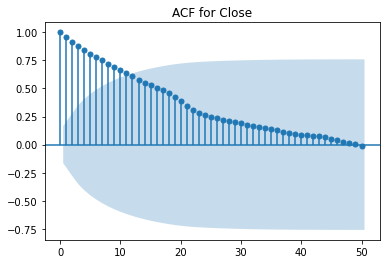

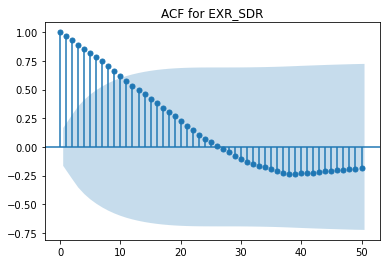

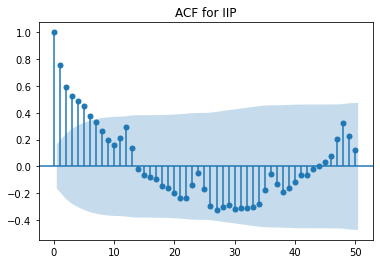

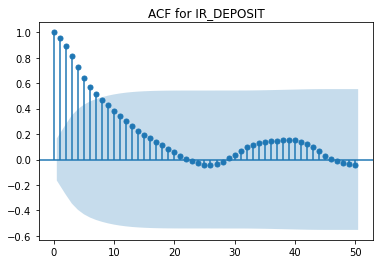

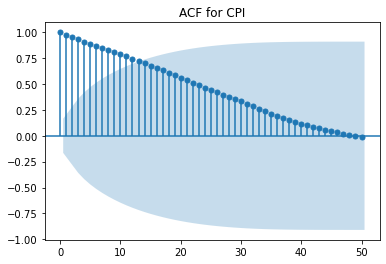

In [53]:
for col in hose_macro.columns:
    plot_acf(hose_macro[col], lags = 50)
    plt.title(f"ACF for {col}" ) 
    plt.show()

In [54]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for col in hose_macro_log.columns:
    print(f'Augmented Dickey-Fuller Test: {col}')
    augmented_dickey_fuller_statistics(hose_macro_log[col])
    print(f'Augmented Dickey-Fuller Test: Differenced {col}')
    augmented_dickey_fuller_statistics(hose_macro_log[col].diff().dropna())
    print("\n")

Augmented Dickey-Fuller Test: Close
ADF Statistic: -0.120620
p-value: 0.947346
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced Close
ADF Statistic: -4.877119
p-value: 0.000039
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


Augmented Dickey-Fuller Test: EXR_SDR
ADF Statistic: -2.229063
p-value: 0.195867
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fuller Test: Differenced EXR_SDR
ADF Statistic: -8.192609
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


Augmented Dickey-Fuller Test: IIP
ADF Statistic: -3.010515
p-value: 0.033924
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced IIP
ADF Statistic: -2.706793
p-value: 0.072870
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


Augmented Dickey-Fuller Test: IR_DEPOSIT
ADF Statistic: -2.298457
p-value: 0.172466
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fulle

In [55]:
vec_rank1 = select_coint_rank(hose_macro_log, 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
print(vec_rank1.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          46.83          37.16
  1   2          26.20          30.82
-------------------------------------


In [57]:
select_order(hose_macro_log, maxlags = 15, deterministic="cili").summary()

,AIC,BIC,FPE,HQIC
0,-37.11,-36.21*,7.629e-17,-36.75
1,-37.36,-35.89,5.949e-17*,-36.77*
2,-37.28,-35.25,6.487e-17,-36.46
3,-37.23,-34.63,6.929e-17,-36.17
4,-37.12,-33.95,7.878e-17,-35.83
5,-37.08,-33.34,8.431e-17,-35.56
6,-36.98,-32.69,9.568e-17,-35.24
7,-36.90,-32.03,1.092e-16,-34.92
8,-36.98,-31.55,1.075e-16,-34.77
9,-36.86,-30.86,1.305e-16,-34.42


In [58]:
vecm = VECM(endog = hose_macro_log, 
            k_ar_diff = 1, 
            coint_rank = 1, 
            deterministic = "cili")
vecm_fit = vecm.fit()
vecm_summary = vecm_fit.summary()

In [60]:
for tab in vecm_fit.summary().tables[5:]:
    print(tab.to_csv())

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Close,0.2932,0.075,3.915,0.000,0.146,0.440
L1.EXR_SDR,-0.4298,0.479,-0.897,0.370,-1.369,0.509
L1.IIP,0.0626,0.052,1.214,0.225,-0.038,0.164
L1.IR_DEPOSIT,0.2849,0.085,3.360,0.001,0.119,0.451
L1.CPI,-2.9341,0.809,-3.627,0.000,-4.520,-1.349
,coef,std err,z,P>|z|,[0.025,0.975]
L1.Close,0.0015,0.014,0.103,0.918,-0.026,0.029
L1.EXR_SDR,0.2770,0.091,3.059,0.002,0.100,0.455
L1.IIP,0.0033,0.010,0.339,0.735,-0.016,0.022
L1.IR_DEPOSIT,0.0009,0.016,0.054,0.957,-0.031,0.032


In [61]:
#
vecm_fit.test_inst_causality( causing= [ 'EXR_SDR',"IIP", 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
12.14,9.488,0.016,4


In [62]:
vecm_fit.test_granger_causality( caused = "Close", causing= [ 'EXR_SDR', "IIP",'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
2.608,1.954,0.008,"(8, 605)"


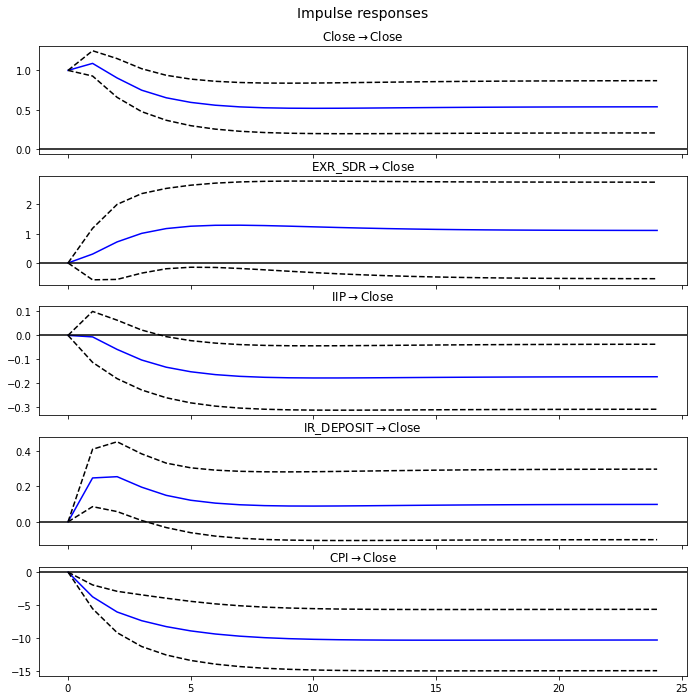

In [63]:
_ = vecm_fit.irf(24).plot(response = "Close", orth=False)

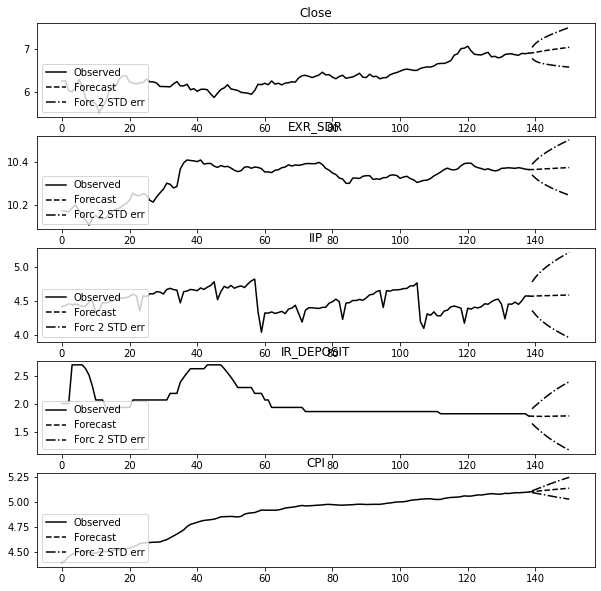

In [64]:
vecm_fit.plot_forecast(steps = 12)

In [65]:
vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
6253.,18.31,0.000,10


In [66]:
vecm_fit.test_whiteness(nlags=20, adjusted=True).summary()

Test statistic,Critical value,p-value,df
543.5,521.5,0.011,470
